In [21]:
import os
import pyxdf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import filtfilt, iirnotch, detrend, butter, cheby1, lfilter
import digital_processing as dp
import feature_extraction as fe

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import svm
from sklearn.feature_selection import RFECV, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler



def bandpass_filter(input_signal, sr, lowcut, highcut, order=5):
    
    nyq = 0.5 * sr # Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    output_signal = filtfilt(b, a, input_signal)
    
    return output_signal

def filter_signals(emg_stream):
    # Set variables
    l_bandpass = 10
    h_bandpass = 400
    sample_rate = int(emg_stream['info']['nominal_srate'][0])

    # Get signal information from the XDF file and apply filters
    l_ear_emg = emg_stream["time_series"][:, 0] - emg_stream["time_series"][:, 1] # Left ear EMG
    l_ear_emg = bandpass_filter(detrend(l_ear_emg), sample_rate, l_bandpass, h_bandpass)

    r_ear_emg = emg_stream["time_series"][:, 2] - emg_stream["time_series"][:, 3] # Right ear EMG
    r_ear_emg = bandpass_filter(detrend(r_ear_emg), sample_rate, l_bandpass, h_bandpass)

    return l_ear_emg, r_ear_emg

def plot_signal(signal, n_ear = ""):
    # Plot signals
    plt.figure(figsize=(10,3))

    plt.plot(signal)
    plt.title(f"{n_ear.capitalize()} Ear")

    plt.show()

def structure_data(emg_stream, EMGinfo_stream, ear_class, ear_emg, sample_rate, time_window=0.5):

    if emg_stream["time_stamps"][0] - EMGinfo_stream["time_stamps"][0] > 0: # This condition is true when EMG signal starts recording AFTER the classification, which makes no sense

        # Find the closest timestamp in the EMGinfo stream to the first timestamp in the EMG stream
        emg_first_timestamp = emg_stream["time_stamps"][0]
        emginfo_timestamps = EMGinfo_stream["time_stamps"]

        closest_index = np.abs(emginfo_timestamps - emg_first_timestamp).argmin()
        print(f"EMG stream starts after classification stream. Closest index: {closest_index}")
    else:
        closest_index = 0
        print(f"EMG stream starts at the same time as the classification stream. Closest index: {closest_index}")
    
    # prev_idx = closest_index

    # This code will extract a window of EMG data before each class label in the EMGinfo stream and store it in a DataFrame
    # Corresponding number of samples based on frequency and the time window
    samples_window = int(sample_rate * time_window)

    # Create an empty DataFrame
    columns = ['class_label'] + ["stream_idx"] + [f'emg_{i}' for i in range(samples_window)]
    df = pd.DataFrame(columns=columns)

    for class_time, class_label in zip(EMGinfo_stream['time_stamps'][closest_index:], ear_class):
        # Find the closest timestamp in the EMG stream
        idx = np.abs(emg_stream['time_stamps'] - class_time).argmin()
        
        # Check if we can extract a full window of data without going out of bounds
        if idx >= samples_window: #and idx - prev_idx > sample_rate * time_window:
            # Extract EMG data for the window
            emg_data_window = ear_emg[idx - samples_window:idx]
            
            # Append to the DataFrame
            row_data = [class_label] + [idx] + emg_data_window.tolist()
            df.loc[len(df)] = row_data

            # prev_idx = idx
    
    return df

def get_features(ear_df, sample_rate, time_window=0.5, name=""):

    frame = int(time_window*sample_rate) # Number of samples in the time window

    ear_df_values = ear_df.iloc[:, 2:].values # Get the values of the EMG data from the 2nd column onwards

    output_df = pd.DataFrame()  # Create an empty dataframe to store the outputs

    for row in ear_df_values:
        features_df, _ = fe.features_estimation(row, name, sample_rate, frame, 1, plot=False, verbose=False)  # Call the features_estimation function
        output_df = pd.concat([output_df, features_df], axis=1)  # Concatenate the features dataframe to the output dataframe column by column

    return pd.concat([ear_df.reset_index(drop=True), output_df.T.reset_index(drop=True)], axis=1) # Concatenate the output dataframe with the original dataframe

def filter_signals_2(emg_stream):

    # Set variables
    l_bandpass = 10
    h_bandpass = 400
    sample_rate = int(emg_stream['info']['nominal_srate'][0])

    l_ear_emg = emg_stream["time_series"][:, 0] - emg_stream["time_series"][:, 1] # Left ear EMG
    r_ear_emg = emg_stream["time_series"][:, 2] - emg_stream["time_series"][:, 3] # Right ear EM

    # Filter the 50Hz armonics (50, 100, 150, 200 Hz)
    for i in range(50, 250, 50):
        l_ear_notch = dp.notch_filter(l_ear_emg, sample_rate, i, False)
        r_ear_notch = dp.notch_filter(r_ear_emg, sample_rate, i, False)

    # Apply bandpass filters 
    l_ear_bandpass = dp.bp_filter(l_ear_notch, l_bandpass, h_bandpass, sample_rate, False)
    r_ear_bandpass = dp.bp_filter(r_ear_notch, l_bandpass, h_bandpass, sample_rate, False)

    # Apply wavelet denoising
    l_ear_denoise = dp.denoisewavelet(l_ear_bandpass)
    r_ear_denoise = dp.denoisewavelet(r_ear_bandpass)

    return l_ear_denoise, r_ear_denoise

def process_xdf(path):
    
    folders = path.split("/")[:-1]
    folder = "/".join(folders)
    
    csv_file_l = folder + '/l_ear_features_' + folders[-1] + '.csv'
    csv_file_r = folder + '/r_ear_features_' + folders[-1] + '.csv'

    print(f"Data in folder {folder} is being processed.")

    print("Checking if csv files exist.")
    if os.path.exists(csv_file_l) and os.path.exists(csv_file_r):
        print("Files exist. Loading csv files.")
        l_ear_features_df = pd.read_csv(csv_file_l)
        r_ear_features_df = pd.read_csv(csv_file_r)
    
    else:
        print("Files do not exist. Creating csv files.")
        data, _ = pyxdf.load_xdf(path)

        EMGinfo_stream = [stream for stream in data if stream["info"]["name"][0] == "EMGinfo"][0]
        emg_stream = [stream for stream in data if "eegoSports " in stream["info"]["name"][0]][0]

        sample_rate = int(emg_stream['info']['nominal_srate'][0])
        time_window = 0.5

        l_ear_emg, r_ear_emg = filter_signals_2(emg_stream)
        l_ear_class = EMGinfo_stream["time_series"][:, 6]
        r_ear_class = EMGinfo_stream["time_series"][:, 7]

        l_ear_df = structure_data(emg_stream, EMGinfo_stream, ear_class=l_ear_class, ear_emg=l_ear_emg, sample_rate=sample_rate)
        r_ear_df = structure_data(emg_stream, EMGinfo_stream, ear_class=r_ear_class, ear_emg=r_ear_emg, sample_rate=sample_rate)

        l_ear_features_df = get_features(l_ear_df, sample_rate, time_window, "left")
        r_ear_features_df = get_features(r_ear_df, sample_rate, time_window, "right")
        l_ear_features_df.to_csv(folder + '/l_ear_features_' + folders[-1] + '.csv', index=False)
        r_ear_features_df.to_csv(folder + '/r_ear_features_' + folders[-1] + '.csv', index=False)

    return l_ear_features_df, r_ear_features_df



### SVM

In [2]:
dataframes = []
concatenated_df = pd.DataFrame()
for i in range(2,10):
    if i == 5:
        continue
    print("Session", i)
    left = pd.read_csv("Data/AM001/s" + str(i) + "/l_ear_features_s" + str(i) + ".csv")
    dataframes.append(left)
concatenated_df = pd.concat(dataframes)
display(concatenated_df)
    

Session 2
Session 3
Session 4
Session 6
Session 7
Session 8
Session 9


,class_label,stream_idx,emg_0,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,...,ZC,WAMP,MYOP,FR,MNP,TP,MNF,MDF,PKF,WENT
0,0.0,1217.0,7.471838,7.208874,6.932305,6.626302,6.269118,5.908270,5.560078,5.131211,...,20.0,0.0,0.0,254.360903,24.248341,12390.902072,22.444576,21.484375,13.671875,0.243545
1,0.0,1517.0,-3.554263,-3.735339,-3.940136,-4.137037,-4.315968,-4.464700,-4.563327,-4.640663,...,21.0,0.0,0.0,457.063492,22.039012,11261.935011,20.886425,21.484375,15.625000,0.129310
2,0.0,1817.0,-7.160666,-7.255778,-7.318898,-7.333633,-7.289570,-7.188394,-7.023820,-6.831350,...,20.0,0.0,0.0,172.940017,17.043999,8709.483614,21.932070,21.484375,21.484375,0.125526
3,0.0,2117.0,-4.455416,-4.042587,-3.620919,-3.142461,-2.579465,-1.936783,-1.194241,-0.384532,...,20.0,0.0,0.0,549.634735,17.392834,8887.738229,21.818985,19.531250,19.531250,0.229818
4,0.0,2418.0,-0.162493,0.117161,0.372365,0.617214,0.818325,0.966999,1.090219,1.197544,...,23.0,0.0,0.0,111.888896,14.915130,7621.631422,25.966648,27.343750,27.343750,0.302018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,0.0,1039349.0,-2.313997,-2.633366,-2.943887,-3.235883,-3.497015,-3.732734,-3.940140,-4.111980,...,22.0,0.0,0.0,60.867405,8.597235,4393.187253,24.736079,23.437500,25.390625,0.295522
2573,0.0,1039750.0,0.913021,0.563745,0.183164,-0.237456,-0.695976,-1.197453,-1.736209,-2.307489,...,19.0,0.0,0.0,26.683967,28.588482,14608.714164,33.602679,19.531250,13.671875,0.248094
2574,0.0,1040152.0,1.183751,1.244642,1.295767,1.336543,1.362689,1.372169,1.363415,1.333879,...,17.0,0.0,0.0,193.411223,37.424916,19124.132072,32.755751,23.437500,19.531250,0.639915
2575,0.0,1040553.0,3.564527,3.589610,3.599955,3.602423,3.601979,3.592507,3.573937,3.550581,...,23.0,0.0,0.0,510.480399,52.700039,26929.719779,31.669508,23.437500,17.578125,0.488997


In [24]:
dataset = concatenated_df.iloc[:,1002:]

X = concatenated_df.iloc[:, 1002:].values # Use only the features extracted from the EMG data
y = concatenated_df['class_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)

# Apply transform to train and test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Define the model
svm_model = svm.SVC(class_weight="balanced", C= 1, gamma= 1, kernel="rbf")

# Perform the grid search on the training data
svm_model.fit(X_train, y_train)
print("Score:", svm_model.score(X_test, y_test))
# cv_score = cross_val_score(svm_model, X_train, y_train, cv=5)
# print("Cross validation score:", cv_score.mean(), "with standard deviation of", cv_score.std())


Score: 0.5906024096385543


### Random Forests

In [54]:
dataset = concatenated_df.iloc[:,1002:]

X = concatenated_df.iloc[:, 1002:].values # Use only the features extracted from the EMG data
y = concatenated_df['class_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)

# Apply transform to train and test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Define the model
rf_model = RandomForestClassifier()

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 500],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

# Setup GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=2, scoring='accuracy', verbose=2)

# Perform the grid search on the training data
grid_search_rf.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search_rf.best_params_)
print("Best accuracy found: ", grid_search_rf.best_score_)

# Optionally, evaluate the best model found on the test set
best_rf_model = grid_search_rf.best_estimator_
test_accuracy = best_rf_model.score(X_test, y_test)
print("Test set accuracy of the best model: ", test_accuracy)

Fitting 2 folds for each of 108 candidates, totalling 216 fits
[CV] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.8s
[CV] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.9s
[CV] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   9.6s
[CV] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   9.7s
[CV] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=5

### LDA

In [40]:
dataset = concatenated_df.iloc[:,1002:]

X = concatenated_df.iloc[:, 1002:].values # Use only the features extracted from the EMG data
y = concatenated_df['class_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)

# Apply transform to train and test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Define the model
lda_model = LinearDiscriminantAnalysis(solver="svd")

# Perform the grid search on the training data
lda_model.fit(X_train, y_train)
print("Score:", lda_model.score(X_test, y_test))
cv_score = cross_val_score(lda_model, X_train, y_train, cv=15)
print("Cross validation score:", cv_score.mean(), "with standard deviation of", cv_score.std())


Score: 0.6375903614457832
Cross validation score: 0.6222211876529051 with standard deviation of 0.012128816473811147


### XGboost

In [56]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
dataset = concatenated_df.iloc[:,1002:]

X = concatenated_df.iloc[:, 1002:].values # Use only the features extracted from the EMG data
y = concatenated_df['class_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)

# Apply transform to train and test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 62.84%


### PCA

In [41]:
dataset = concatenated_df.iloc[:,1002:]

X = concatenated_df.iloc[:, 1002:].values # Use only the features extracted from the EMG data
y = concatenated_df['class_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [42]:

scaler = StandardScaler()
scaler.fit(X_train)
print(X_train[0])

# Apply transform to train and test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print(X_train[0])

[3.54535084e+01 5.95691247e+00 5.05518887e+03 5.05518887e+00
 1.75906414e+00 3.76222983e+02 3.76222983e-01 6.51731192e-01
 2.80000000e+01 0.00000000e+00 0.00000000e+00 2.84809793e+01
 3.47507343e+01 1.77576252e+04 2.32185004e+01 1.95312500e+01
 1.95312500e+01 2.30047205e-01]
[-0.31828446 -0.49196176 -0.42896779 -0.42896779 -0.22031171 -0.51394604
 -0.51394604 -0.57382827 -0.6701765  -0.62122395 -0.94273411 -0.29250439
 -0.31827952 -0.31827952 -0.88699668 -0.74189045 -0.444768   -1.03756085]


In [43]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(0.95)
pca.fit(X_train) # Fit PCA on standardized training data
print(pca.n_components_) # Print the number of components that explain 95% of the variance

X_train_pca = pca.transform(X_train) # Transform the training data
X_test_pca = pca.transform(X_test) # Transform the test data
print(X_train.shape)
print(X_train_pca.shape)

6
(16597, 18)
(16597, 6)


In [44]:
most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.n_components_)]
feature_names = concatenated_df.columns[1002:]
most_important_names = [feature_names[most_important[i]] for i in range(pca.n_components_)]
print(most_important_names)
print(most_important)

['DASDV', 'WAMP', 'FR', 'MYOP', 'WAMP', 'PKF']
[7, 9, 11, 10, 9, 16]


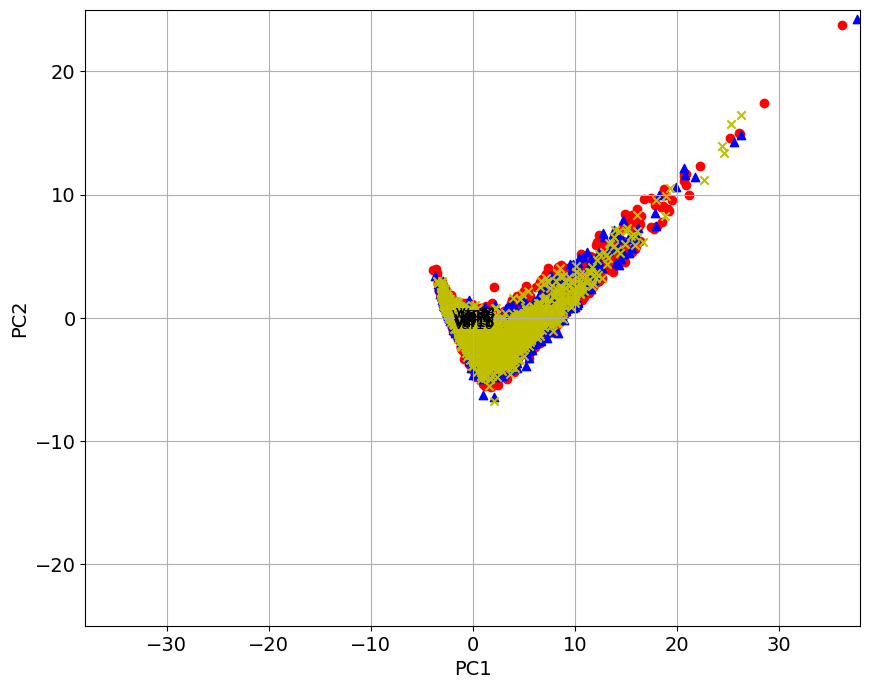

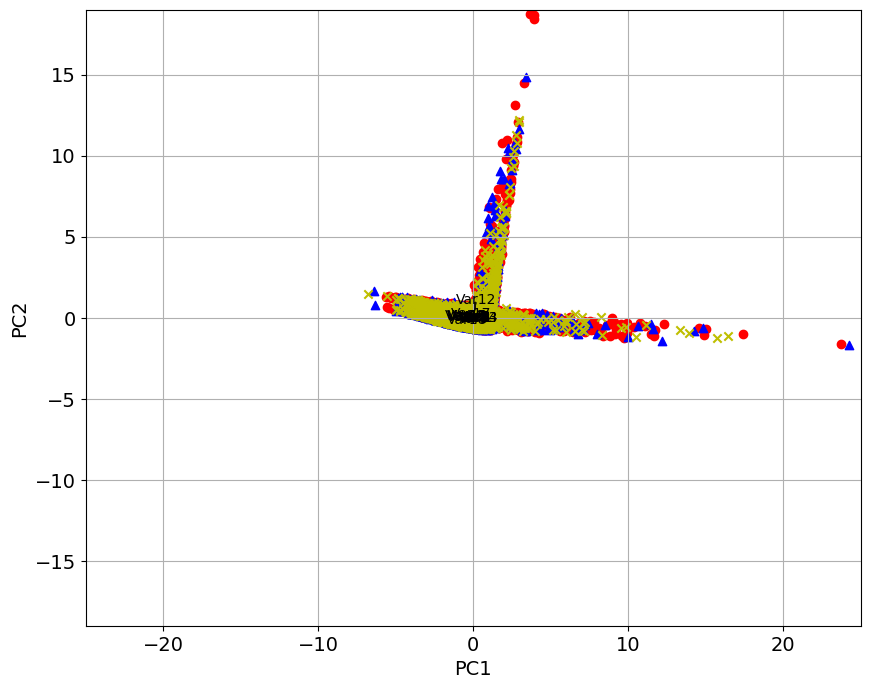

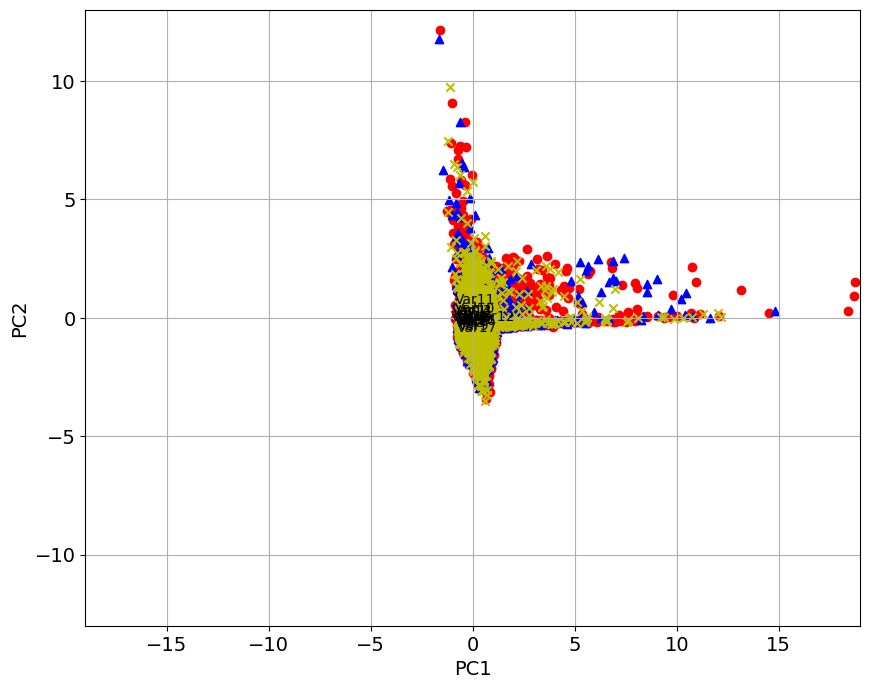

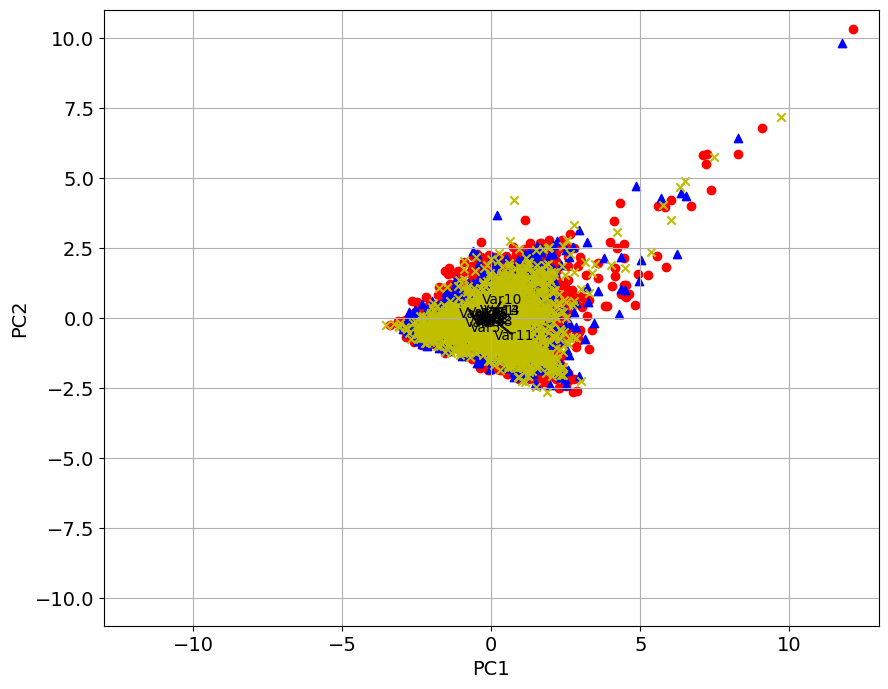

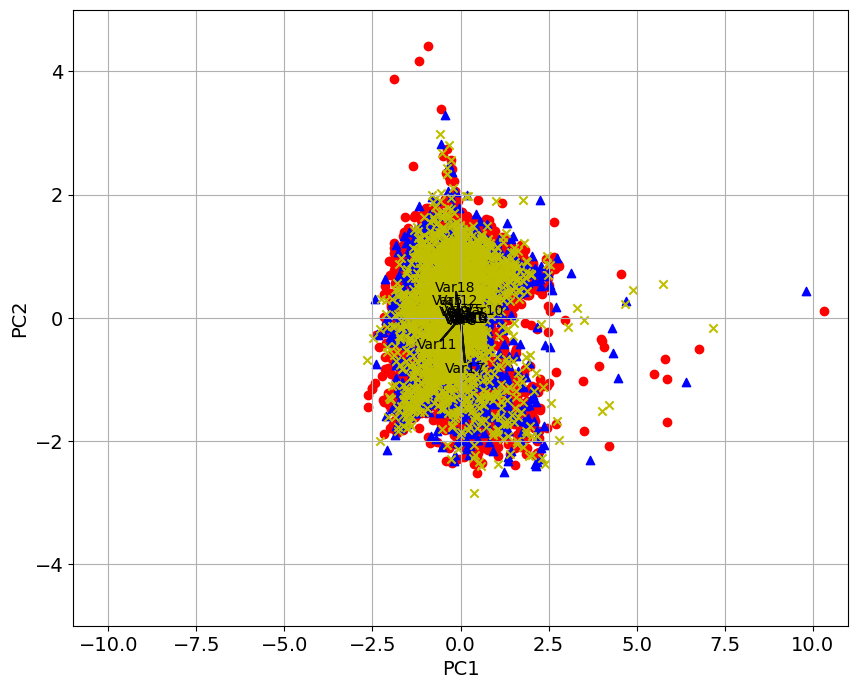

In [65]:
# Biplot
def biplot(score, coeff , y):
    '''
    Author: Serafeim Loukas, serafeim.loukas@epfl.ch
    Inputs:
       score: the projected data
       coeff: the eigenvectors (PCs)
       y: the class labels
   '''
    xs = score[:,0] # projection on PC1
    ys = score[:,1] # projection on PC2
    n = coeff.shape[0] # number of variables
    plt.figure(figsize=(10,8), dpi=100)
    classes = np.unique(y)
    colors = ['r','b','y']
    markers=['o','^','x']
    for s,l in enumerate(classes):
        plt.scatter(xs[y==l],ys[y==l], c = colors[s], marker=markers[s]) # color based on group
    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'k', alpha = 0.9,linestyle = '-',linewidth = 1.5, overhang=0.2)
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center',fontsize=10)

    plt.xlabel("PC{}".format(1), size=14)
    plt.ylabel("PC{}".format(2), size=14)
    limx= int(xs.max()) + 1
    limy= int(ys.max()) + 1
    plt.xlim([-limx,limx])
    plt.ylim([-limy,limy])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)

biplot(X_train_pca[:, 0:2], np.transpose(pca.components_[0:2, :]), y_train)
biplot(X_train_pca[:, 1:3], np.transpose(pca.components_[1:3, :]), y_train)
biplot(X_train_pca[:, 2:4], np.transpose(pca.components_[2:4, :]), y_train)
biplot(X_train_pca[:, 3:5], np.transpose(pca.components_[3:5, :]), y_train)
biplot(X_train_pca[:, 4:6], np.transpose(pca.components_[4:6, :]), y_train)


In [46]:
pca.explained_variance_ratio_

array([0.66845171, 0.15100325, 0.05203102, 0.04832242, 0.02976649,
       0.02735103])

In [47]:
# Apply SVM on PCA data

svm_model = svm.SVC(class_weight="balanced", C= 1, gamma= 1, kernel="rbf")

svm_model.fit(X_train_pca, y_train)
print("Score:", svm_model.score(X_test_pca, y_test))
cv_score = cross_val_score(svm_model, X_train_pca, y_train, cv=5)
print("Cross-validation score, MEAN:", cv_score.mean(), "with STD:", cv_score.std())

Score: 0.5759036144578313
Cross-validation score, MEAN: 0.5855877986183964 with STD: 0.00808227952139481


In [49]:
# Apply RF on PCA data

rf_model = RandomForestClassifier(n_estimators=100)

rf_model.fit(X_train_pca, y_train)
print("Score:", rf_model.score(X_test_pca, y_test))
cv_score = cross_val_score(rf_model, X_train_pca, y_train, cv=5)
print("Cross-validation score, MEAN:", cv_score.mean(), "with STD:", cv_score.std())

Score: 0.6306024096385542
Cross-validation score, MEAN: 0.6228230668985069 with STD: 0.006738742908993265


### SMV on most important features
(based on PCA)

In [32]:
X = concatenated_df[most_important_names].values # Use only the features extracted from the PCA
y = concatenated_df['class_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define the model
svm_model = svm.SVC(class_weight="balanced", C= 1, gamma= 1, kernel="rbf")

# Perform the grid search on the training data
svm_model.fit(X_train, y_train)
print("Score:", svm_model.score(X_test, y_test))
cv_score = cross_val_score(svm_model, X_train, y_train, cv=5)
print("Cross validation score:", cv_score.mean(), "with standard deviation of", cv_score.std())


Score: 0.5486746987951807
Cross validation score: 0.54226657760902 with standard deviation of 0.00789579757090227
